# 01. Baseline

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

PATH = "../../data/sound/mixkit-light-rain-loop-2393.wav"

In [2]:
n_fft = 1024
sample_rate = 16000 # Hz
frame_len = 0.025 # L = 25 ms
frame_step = 0.010 # H = 10 ms
win_len = int(frame_len * sample_rate)
hop_len = int(frame_step * sample_rate)
n_mels = 80 # mel bins
fmin = 20 # Hz
fmax = min(8000, sample_rate // 2) # Hz
assert n_fft >= win_len

In [3]:
waveform, sr = librosa.load(PATH, sr=sample_rate)

In [4]:
print(f"{waveform.shape=} {sr=}")

waveform.shape=(240000,) sr=16000


Text(0, 0.5, 'Amplitude')

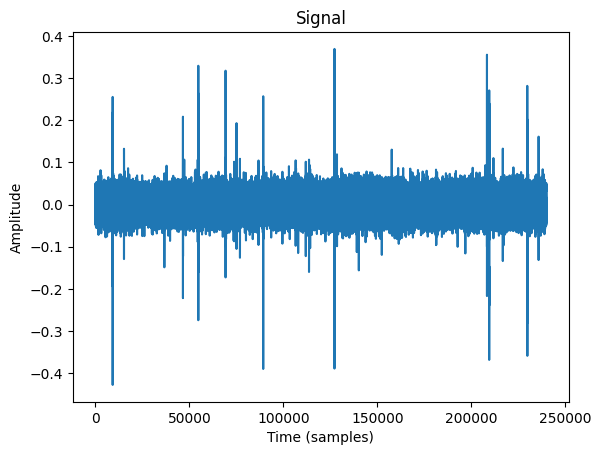

In [5]:
plt.plot(waveform)
plt.title("Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Short time Fourier transform

Text(0, 0.5, 'Amplitude')

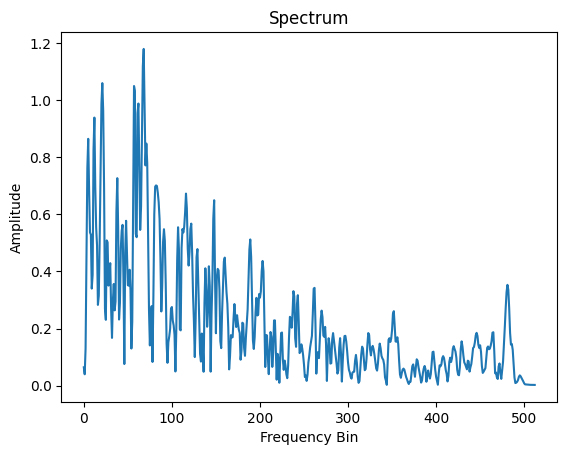

In [6]:
ft = np.abs(librosa.stft(waveform[:n_fft], hop_length=n_fft+1, n_fft=n_fft))
plt.plot(ft)
plt.title("Spectrum")
plt.xlabel("Frequency Bin")
plt.ylabel("Amplitude")

In [7]:
ft.shape

(513, 1)

## Spectrogram

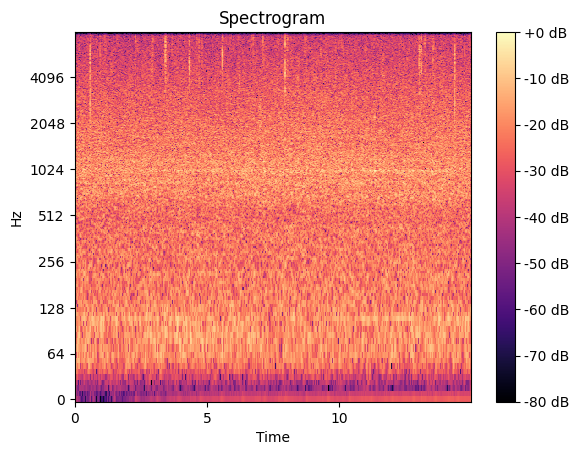

In [8]:
spec = np.abs(librosa.stft(waveform, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In [9]:
spec.shape

(1025, 469)

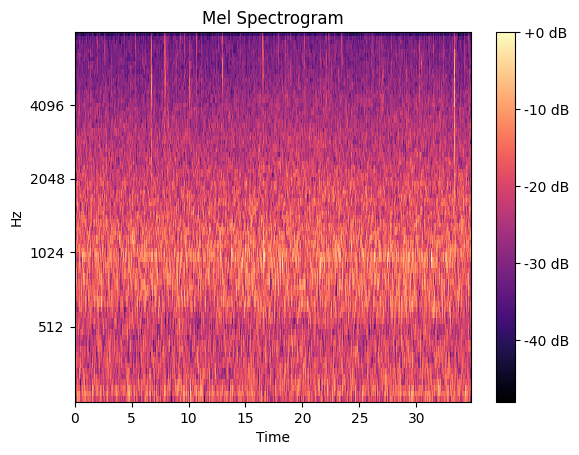

In [10]:
librosa_mel_spec = librosa.feature.melspectrogram(
    y=waveform,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_len,
    win_length=win_len,
    center=True,
    pad_mode="constant",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    fmin=fmin,
    fmax=fmax,
)
librosa.display.specshow(
    librosa.power_to_db(librosa_mel_spec, ref=np.max),
    y_axis="mel",
    fmin=fmin,
    fmax=fmax,
    x_axis="time",
)
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")

# 02. Torchaudio

In [11]:
import torch
from torchaudio.transforms import MelSpectrogram

In [12]:
waveform = torch.Tensor(waveform)

In [13]:
torchaudio_mel_spec = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_len,
    hop_length=hop_len,
    center=True,
    pad_mode="constant",
    power=2.0,
    norm='slaney',
    mel_scale='slaney',
    n_mels=n_mels,
    f_min=fmin,
    f_max=fmax,
)(waveform)

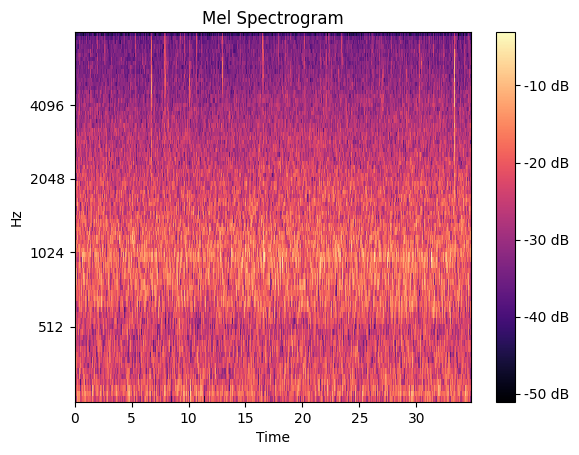

In [14]:
librosa.display.specshow(
    librosa.power_to_db(torchaudio_mel_spec.numpy()),
    y_axis="mel",
    fmin=fmin,
    fmax=fmax,
    x_axis="time",
)
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")

torch.Size([80, 1501]) (80, 1501)
MSE 4.46335541226181e-16


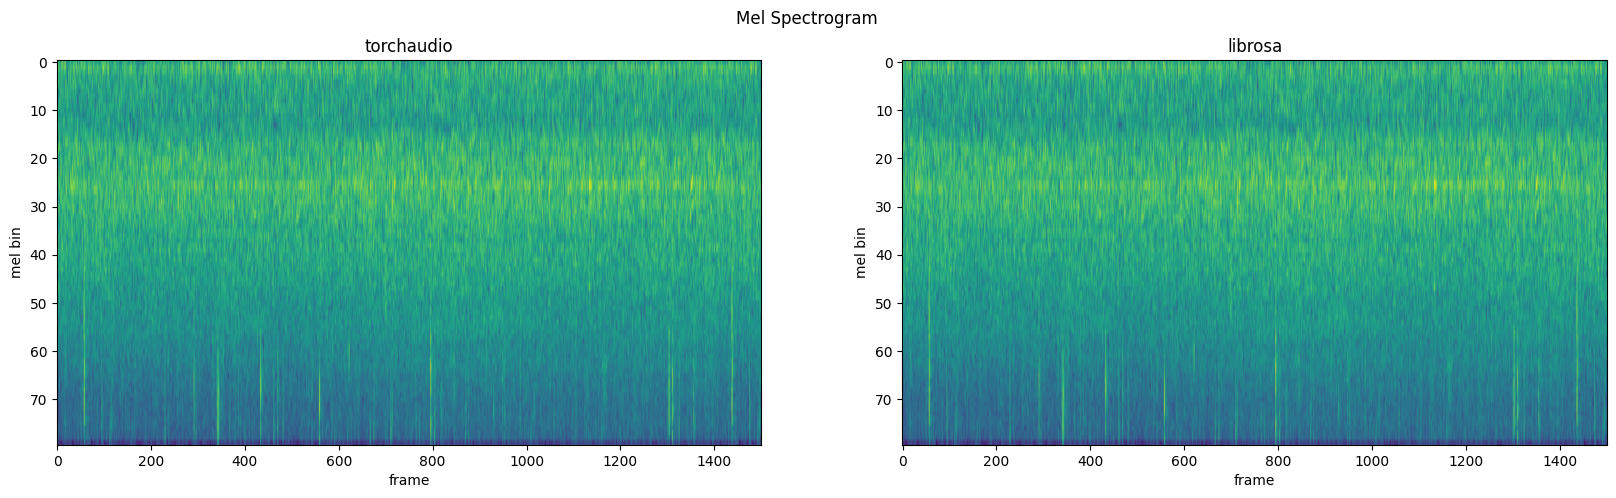

In [15]:
print(torchaudio_mel_spec.shape, librosa_mel_spec.shape)

mse = ((torchaudio_mel_spec.numpy() - librosa_mel_spec) ** 2).mean()
print("MSE", mse.item())

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Mel Spectrogram')

axs[0].set_title('torchaudio')
axs[0].set_ylabel('mel bin')
axs[0].set_xlabel('frame')
axs[0].imshow(librosa.power_to_db(torchaudio_mel_spec), aspect='auto')

axs[1].set_title('librosa')
axs[1].set_ylabel('mel bin')
axs[1].set_xlabel('frame')
axs[1].imshow(librosa.power_to_db(librosa_mel_spec), aspect="auto")

plt.show()

# 03. Mel Spectrogram from scratch with Numpy

In [16]:
waveform, sr = librosa.load(PATH, sr=sample_rate)
print(f"{waveform.shape=} {sr=}")

waveform.shape=(240000,) sr=16000


Text(0, 0.5, 'Amplitude')

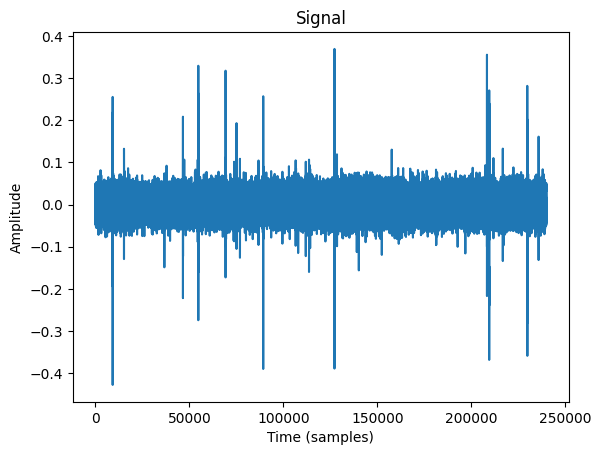

In [17]:
plt.plot(waveform)
plt.title("Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Pre-Emphasis filter


In [18]:
# Commented pre-emphasis to match librosa and torchaudio
#
# alpha = 0.97
# waveform = np.append(waveform[0], waveform[1:] - alpha * waveform[:-1])

Text(0, 0.5, 'Amplitude')

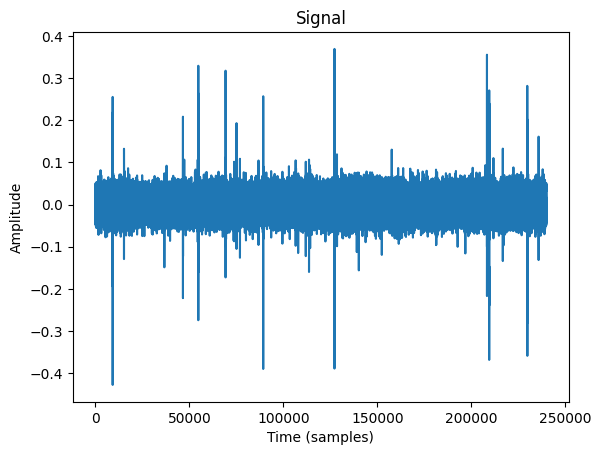

In [19]:
plt.plot(waveform)
plt.title("Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Split into frames

In [20]:
n_frames = 1 + (len(waveform) - win_len) // hop_len
print(len(waveform), win_len, hop_len, n_frames)

240000 400 160 1498


In [21]:
frames = np.stack([waveform[i*hop_len: i*hop_len + win_len] for i in range(n_frames)])

(1498, 400)


Text(0, 0.5, 'Amplitude')

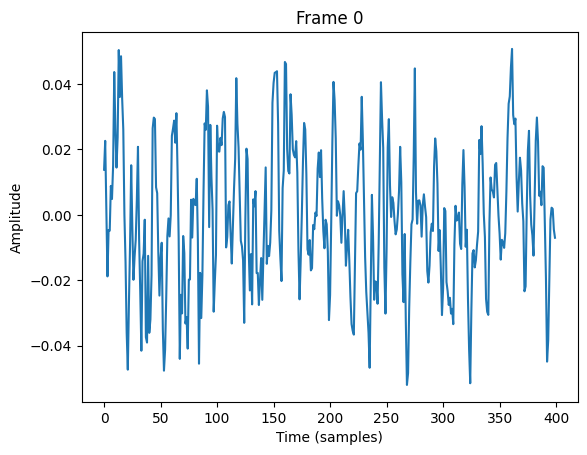

In [22]:
print(frames.shape)
plt.plot(frames[0])
plt.title("Frame 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Hann window

In [23]:
# window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(win_len) / (win_len - 1)))
window = np.hanning(win_len)
print(window.shape)

frames *= window

(400,)


Text(0, 0.5, 'Amplitude')

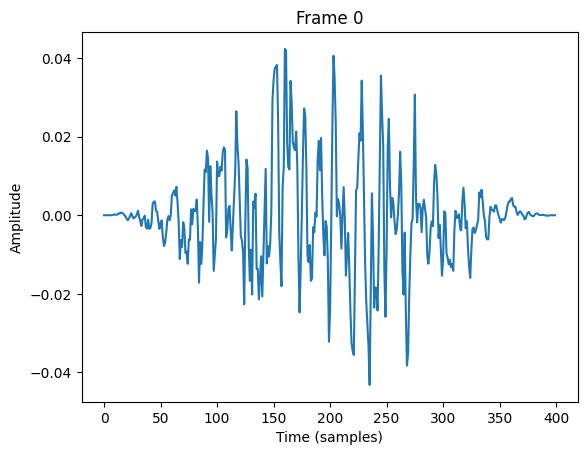

In [24]:
plt.plot(frames[0])
plt.title("Frame 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## Padding

In [25]:
pad_total = n_fft - win_len
pad_left = pad_total // 2
pad_right = pad_total - pad_left

frames_padded = np.pad(frames, ((0, 0), (pad_left, pad_right)))

(1498, 1024)


Text(0, 0.5, 'Amplitude')

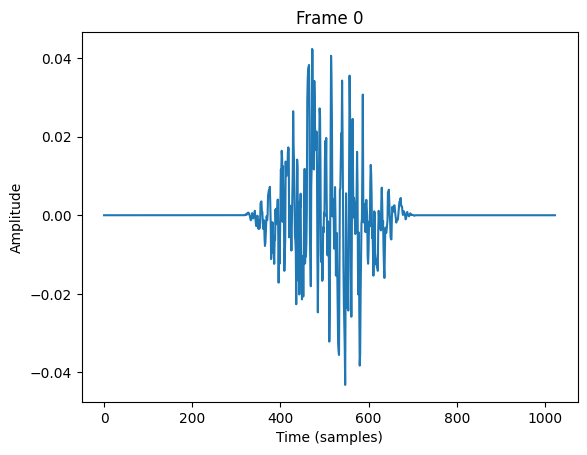

In [26]:
print(frames_padded.shape)
plt.plot(frames_padded[0])
plt.title("Frame 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

## FFT

In [27]:
frames_fft = np.fft.rfft(frames_padded, n_fft)
power_spec = (np.abs(frames_fft) ** 2) / n_fft

(1498, 513)


Text(0, 0.5, 'Power')

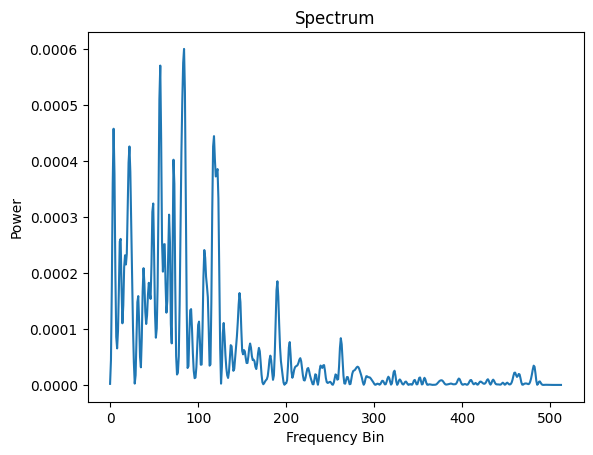

In [28]:
print(power_spec.shape)
plt.plot(power_spec[0])
plt.title("Spectrum")
plt.xlabel("Frequency Bin")
plt.ylabel("Power")

## Mel scale

In [29]:
def hz_to_mel(f_hz):
    return 2595.0 * np.log10(1.0 + f_hz / 700.0)
def mel_to_hz(mel):
    return 700.0 * (10**(mel / 2595.0) - 1.0)

In [30]:
mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), n_mels + 2)
hz_points = mel_to_hz(mel_points)

print(mel_points.shape, hz_points.shape)

(82,) (82,)


## Mel filters

In [31]:
bin_points = np.floor((n_fft + 1) * hz_points / sample_rate).astype(int)
print(bin_points.shape, bin_points)

(82,) [  1   2   4   5   7   8  10  12  14  15  17  19  21  23  26  28  30  32
  35  37  40  43  45  48  51  54  57  61  64  67  71  74  78  82  86  90
  94  99 103 108 113 117 123 128 133 139 145 150 157 163 169 176 183 190
 198 205 213 221 229 238 247 256 265 275 285 295 306 317 328 340 352 364
 377 390 404 418 433 447 463 479 495 512]


In [32]:
mel_filters = np.zeros((n_mels, n_fft // 2 + 1))
for i in range(1, n_mels + 1):
    f_l, f_c, f_r = bin_points[i-1:i+2]

    for k in range(f_l, f_c):
        mel_filters[i-1, k] = (k - f_l) / (f_c - f_l)
    for k in range(f_c, f_r):
        mel_filters[i-1, k] = (f_r - k) / (f_r - f_c)

print(mel_filters.shape)

(80, 513)


In [33]:
slaney_norm = 2.0 / (hz_points[2:] - hz_points[:-2])
print(slaney_norm.shape)

mel_filters *= slaney_norm[:, np.newaxis]

(80,)


## Spectrogram

In [34]:
mel_spec = np.dot(power_spec, mel_filters.T).T

print(mel_spec.shape)

(80, 1498)


In [35]:
eps = 1e-10
mel_spec_db = 10 * np.log10(np.maximum(mel_spec, eps) / np.max(mel_spec))

MSE 0.00021984976545268668


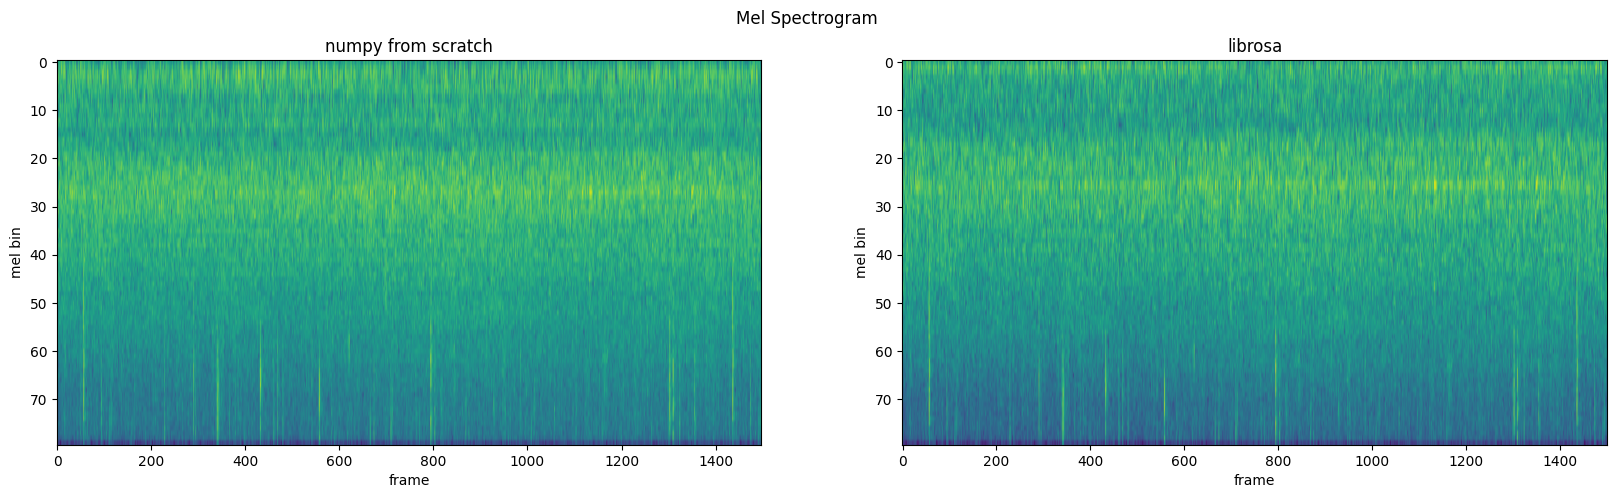

In [36]:
mse = ((mel_spec - librosa_mel_spec[:, 1:mel_spec.shape[1]+1]) ** 2).mean()
print("MSE", mse.item())

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Mel Spectrogram')

axs[0].set_title('numpy from scratch')
axs[0].set_ylabel('mel bin')
axs[0].set_xlabel('frame')
axs[0].imshow(librosa.power_to_db(mel_spec), aspect='auto')

axs[1].set_title('librosa')
axs[1].set_ylabel('mel bin')
axs[1].set_xlabel('frame')
axs[1].imshow(librosa.power_to_db(librosa_mel_spec), aspect="auto")

plt.show()

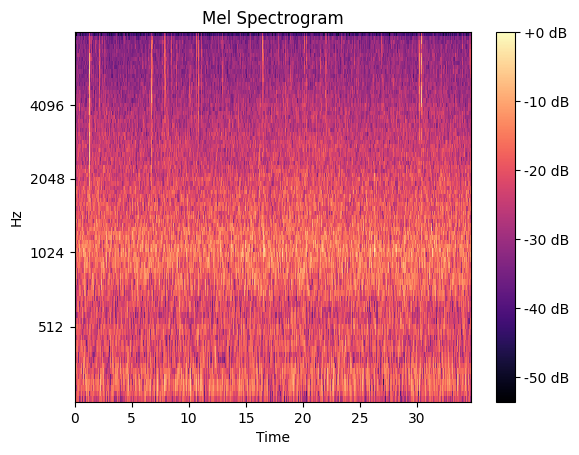

In [37]:
librosa.display.specshow(
    mel_spec_db,
    y_axis="mel",
    fmin=fmin,
    fmax=fmax,
    x_axis="time",
)
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")

## Final

In [38]:
%load_ext autoreload
%autoreload 2

In [39]:
from mel_spectrogram import MelSpectrogram

mel_spec_final = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_len,
    hop_length=hop_len,
    n_mels=n_mels,
    f_min=fmin,
    f_max=fmax,
)(waveform)

mse = ((mel_spec_final - torchaudio_mel_spec[:, 1:mel_spec_final.shape[1]+1].numpy()) ** 2).mean()
print("MSE(numpy_from_scratch, torchaudio) =", mse.item())

MSE(numpy_from_scratch, torchaudio) = 0.00021984970932490422


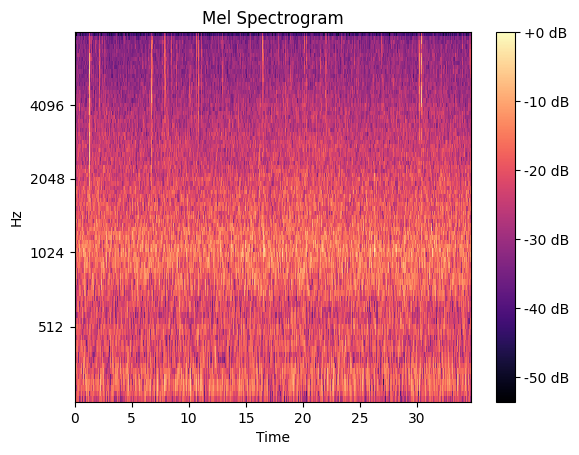

In [42]:
librosa.display.specshow(
    MelSpectrogram.power_to_db(mel_spec_final),
    y_axis="mel",
    fmin=fmin,
    fmax=fmax,
    x_axis="time",
)
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")